<a href="https://colab.research.google.com/github/sarthak-srivastava/Learning-Iterative-Image-Reconstruction/blob/master/NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper: http://www.ais.uni-bonn.de/behnke/papers/ijcai01.pdf

In [0]:
#Lets get started by loading our basic dependencies
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from tqdm import tqdm
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/")

In [21]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [22]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

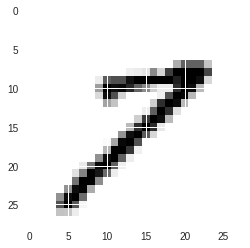

In [23]:
#Let's have a look at a random image
RandomNum = random.randint(0,55000)
image = x_train[RandomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

(784,)

In [73]:
x =[0]*55000
image_label = [0]*55000
image_train = [0]*55000
for i in range(55000):
  x[i] = x_train[i].reshape([28,28])
  image_label[i] = x_train[i].reshape([784,1])
  image_train[i] = resize(x[i], (14,14))

 

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


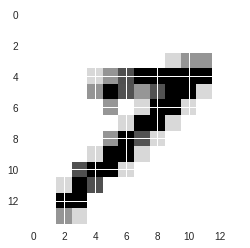

In [69]:
plt.imshow(image_train[RandomNum])
plt.show()

In [0]:
for i in range(55000):
  image_train[i] = image_train[i].reshape([196,1]) 